<a href="https://colab.research.google.com/github/Freedisch/ml-formativeChatbot/blob/main/covidchat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Epoch 1/50
12/12 [==============================] - 2s 3ms/step - loss: 3.6384 - accuracy: 0.0139 
Epoch 2/50
12/12 [==============================] - 0s 3ms/step - loss: 3.5485 - accuracy: 0.0625
Epoch 3/50
12/12 [==============================] - 0s 3ms/step - loss: 3.5426 - accuracy: 0.0694
Epoch 4/50
12/12 [==============================] - 0s 3ms/step - loss: 3.4621 - accuracy: 0.0972
Epoch 5/50
12/12 [==============================] - 0s 3ms/step - loss: 3.3545 - accuracy: 0.1736
Epoch 6/50
12/12 [==============================] - 0s 3ms/step - loss: 3.3407 - accuracy: 0.1458
Epoch 7/50
12/12 [==============================] - 0s 3ms/step - loss: 3.2447 - accuracy: 0.1528
Epoch 8/50
12/12 [==============================] - 0s 3ms/step - loss: 3.1794 - accuracy: 0.1806
Epoch 9/50
12/12 [==============================] - 0s 3ms/step - loss: 3.0213 - accuracy: 0.2222
Epoch 10/50
12/12 [==============================] - 0s 3ms/step - loss: 2.8946 - accuracy: 0.2153
Epoch 11/50
12/12 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


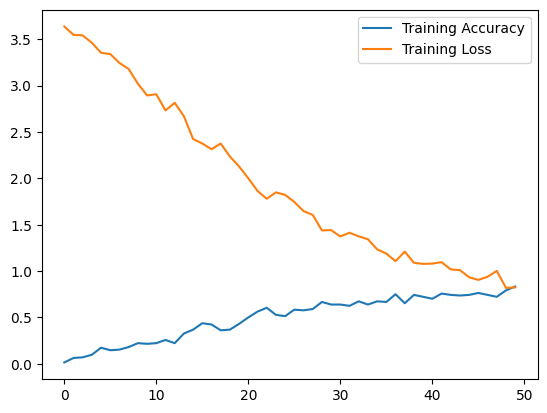

Chatbot is now running
1/1 [==============================] - 0s 67ms/step
Bot: The European Centre for Disease Prevention and Control (ECDC) is in continuous contact with the European Commission and the World Health Organization regarding the assessment of this outbreak. To inform the European Commission and the public health authorities in Member States of the ongoing situation, ECDC publishes daily summaries and continuously assesses the risk for EU citizens. ECDC and WHO have developed technical guidance to support the EU Member States in their response. The European Commission is ensuring the coordination of risk management activities at EU level. Check this link: https://www.ecdc.europa.eu/en/novel-coronavirus-china/questions-answers from the European Centre for Disease Prevention and Control (ECDC)
1/1 [==============================] - 0s 30ms/step
Bot: 
The clinical spectrum of COVID-19 ranges from mild disease with non-specific signs and symptoms of acute respiratory illness,

In [ ]:
import numpy as np
import pandas as pd
import re
import random
import transformers
import matplotlib.pyplot as plt
import json
import pickle
import torch

import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelBinarizer

# Initialize BERT tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_embedding_model = BertModel.from_pretrained('bert-base-uncased')

# Load and clean dataset
data = pd.read_csv("Covidvert.csv").dropna()

# Prepare intents structure
intent_data = {"intents": []}
for i in data.index:
    question = data['question'][i].lower().replace('?', '.').split('.')
    question = [q.strip() for q in question]
    answer = f"{data['answer'][i]} Check this link: {data['link'][i]} from the {data['source'][i]}"
    intent_entry = {
        'tags': data['category'][i],
        'patterns': question[:-1],
        'responses': answer
    }
    intent_data['intents'].append(intent_entry)

# Save intents to JSON
with open("covid_intents.json", "w") as outfile:
    json.dump(intent_data, outfile)

# Load intents from JSON
with open('covid_intents.json') as json_file:
    intents = json.load(json_file)

# Initialize lists for words, classes, and documents
tokens = []
labels = []
docs = []
ignored_characters = ['?', '!', '.', ',']

lemmatizer = WordNetLemmatizer()

# Tokenize and lemmatize words in intents
for intent in intents['intents']:
    for pattern in intent['patterns']:
        if isinstance(pattern, str):
            token_list = bert_tokenizer.tokenize(pattern.strip())
            tokens.extend(token_list)
            docs.append((pattern, intent['tags']))
            if intent['tags'] not in labels:
                labels.append(intent['tags'])

tokens = [lemmatizer.lemmatize(token.lower()) for token in tokens if token not in ignored_characters]
tokens = sorted(set(tokens))
labels = sorted(set(labels))

# Save tokenized words and labels
pickle.dump(tokens, open('tokens.pkl', 'wb'))
pickle.dump(labels, open('labels.pkl', 'wb'))

# Create training data
training_input = []
training_output = []
output_template = [0] * len(labels)

for doc in docs:
    bag_of_words = [1 if token in doc[0].split() else 0 for token in tokens]
    training_input.append(bag_of_words)
    output_row = list(output_template)
    output_row[labels.index(doc[1])] = 1
    training_output.append(output_row)

training_input = np.array(training_input)
training_output = np.array(training_output)

# Build and train neural network model
chatbot_model = Sequential([
    Dense(128, input_shape=(len(training_input[0]),), activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(training_output[0]), activation='softmax')
])

chatbot_model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
training_history = chatbot_model.fit(training_input, training_output, epochs=50, batch_size=12, verbose=1)
chatbot_model.save('chatbot_model.h5')
print('Model training complete')

# Plot training results
plt.plot(training_history.history['accuracy'], label='Training Accuracy')
plt.plot(training_history.history['loss'], label='Training Loss')
plt.legend()
plt.show()

# Load model and data
chatbot_model = load_model('chatbot_model.h5')
with open('covid_intents.json') as json_file:
    intents = json.load(json_file)
tokens = pickle.load(open('tokens.pkl', 'rb'))
labels = pickle.load(open('labels.pkl', 'rb'))

# Adjust BERT embeddings to match model input shape
embedding_transformer = Sequential([
    Dense(len(training_input[0]), input_shape=(768,), activation='relu')
])

def extract_bert_embeddings(text):
    input_tokens = bert_tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        model_outputs = bert_embedding_model(**input_tokens)
    return model_outputs.last_hidden_state.mean(dim=1).detach().numpy()

def classify_text(text):
    embedding = extract_bert_embeddings(text)
    adjusted_embedding = embedding_transformer.predict(embedding)
    prediction = chatbot_model.predict(adjusted_embedding)[0]
    threshold = 0.25
    predictions = [[i, p] for i, p in enumerate(prediction) if p > threshold]
    predictions.sort(key=lambda x: x[1], reverse=True)
    return [{'intent': labels[p[0]], 'probability': str(p[1])} for p in predictions]

def generate_response(predicted_intents, intent_json):
    tag = predicted_intents[0]['intent']
    for intent in intent_json['intents']:
        if tag in intent['tags']:
            return intent['responses']
    return None

# Chatbot interaction loop
print("Chatbot is now running")
while True:
    user_input = input("")
    if user_input.lower() in ['quit', 'exit']:
        print("Goodbye")
        break
    predicted_intents = classify_text(user_input)
    if predicted_intents:
        response = generate_response(predicted_intents, intents)
        print(f"Bot: {response}")
